In [1]:
import response_utils
import adv_diff
import numpy as np
import matplotlib.pyplot as plt
from response_utils import brewer2_light
from scipy.optimize import minimize
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

# Experiment 3: Advection-Diffusion

Text(0, 0.5, '$\\mathbf{x}^\\prime$')

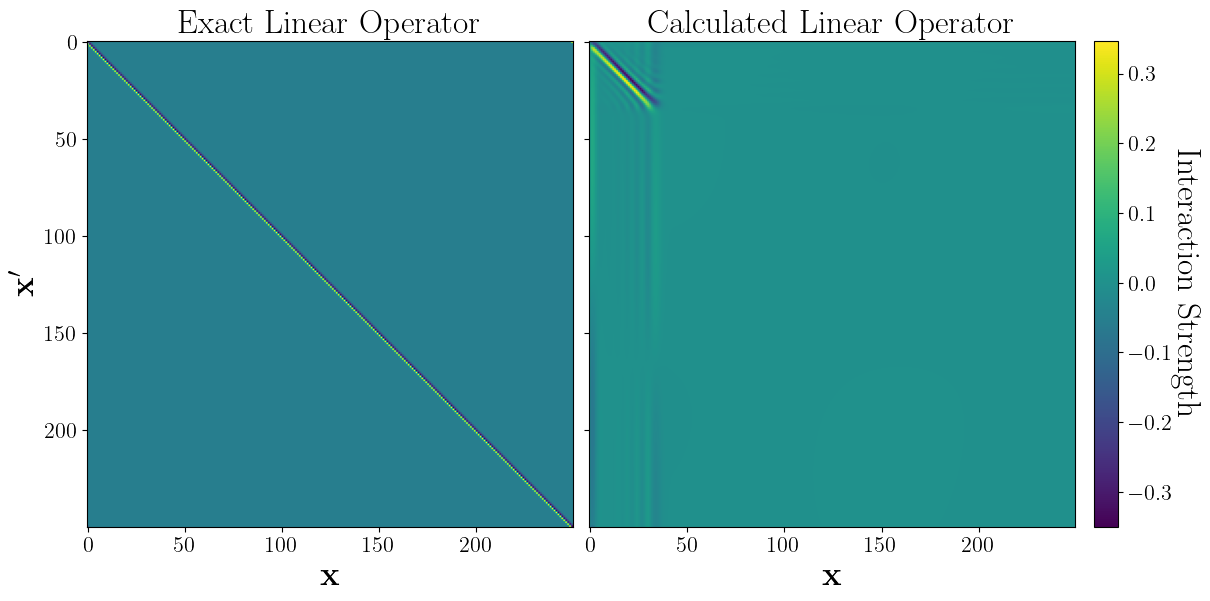

In [48]:
fig, ax = plt.subplots(1,2,figsize=(12,6),sharey=True,constrained_layout=True)
im2 = ax[0].imshow(L)
im = ax[1].imshow(L_raw[r'4xCO$_2$'])
cbar = fig.colorbar(im, fraction=0.05, pad=0.04)
cbar.ax.set_ylabel('Interaction Strength', rotation=270, labelpad=20, fontsize=24)
ax[0].set_title('Exact Linear Operator',fontsize=24)
ax[1].set_title('Calculated Linear Operator',fontsize=24)
ax[0].set_xlabel(r'$\mathbf{x}$',fontsize=24)
ax[1].set_xlabel(r'$\mathbf{x}$',fontsize=24)
ax[0].set_ylabel(r'$\mathbf{x}^\prime$',fontsize=24)


In [2]:
def construct_L(ax, mu, dx, n):
    # Create an empty L matrix of size NxN
    L = np.zeros((n, n))
    
    # Fill in advection (first derivative) part
    for i in range(1, n-1):
        L[i, i-1] = ax / (2 * dx)
        L[i, i+1] = -ax / (2 * dx)
        
    # Fill in diffusion (second derivative) part
    for i in range(1, n-1):
        L[i, i-1] += mu / (dx ** 2)
        L[i, i]   -= 2 * mu / (dx ** 2)
        L[i, i+1] += mu / (dx ** 2)
    
    # Periodic boundary conditions
    L[0, -1] = ax / (2 * dx) + mu / (dx ** 2)  # For u[0] interacting with u[N-1]
    L[0, 1] = -ax / (2 * dx) + mu / (dx ** 2)  # For u[0] interacting with u[1]
    L[0, 0] = -2 * mu / (dx ** 2)

    L[-1, -2] = ax / (2 * dx) + mu / (dx ** 2)  # For u[N-1] interacting with u[N-2]
    L[-1, 0] = -ax / (2 * dx) + mu / (dx ** 2)  # For u[N-1] interacting with u[0]
    L[-1, -1] = -2 * mu / (dx ** 2)
    
    return L


In [3]:
# ODE parameters
ax = 10/5
mu = 3/5
T0 = 0

# Grid parameters
dx = 1
dt = adv_diff.calc_dt_2D(ax, mu, dx)
N_x = 250
N_t = 50
x_final = N_x*dx
t_final = N_t*dt
x = np.arange(0, x_final, dx)
t = np.arange(0, t_final, dt)
t_mesh, x_mesh = np.meshgrid(t, x)

# Construct explicit linear operator
L = construct_L(ax, mu, dx, N_x)

# Forcing parameters
## 2xCO2 and 4xCO2 (constant forcing)
F_2xCO2 = response_utils.F_const(t, 1.0)
F_4xCO2 = response_utils.F_const(t, 2.0)

## RCP70
F_final = 2.6 # (W m^-2)
ts = t_final/2
a_exp = F_final/np.exp(N_t/1.5*dt/ts)
F_exp = response_utils.F_exp(t, a_exp, ts)

## Overshoot
a_over = 4
b_over = t_final*(2/5)
c_over = ts/3
F_over = response_utils.F_over(t, a_over, b_over, c_over)

## Impulse forcing
F0 = 1
F_pulse = response_utils.F_del(t, F0)
F_del = {r'2xCO$_2$':F_pulse,
         r'4xCO$_2$':F_pulse,
         'High Emissions':F_pulse,
         'Overshoot':F_pulse}

## Compile all for diagnosis
F_all = {r'2xCO$_2$':F_2xCO2,
         r'4xCO$_2$':F_4xCO2,
         'High Emissions':F_exp,
         'Overshoot':F_over}

# Plotting parameters
experiments = [r'2xCO$_2$',r'4xCO$_2$','High Emissions','Overshoot']

# Stochastic parameters
#K = 0.5
#N_ensemble = 50

# Generated perturbed ensemble
#F_del_ensemble = response_utils.gen_F_ensemble(F_del, t, K, N_ensemble, experiments)
#F_all_ensemble = response_utils.gen_F_ensemble(F_all, t, K, N_ensemble, experiments)

#ic_zero = np.zeros(N_x)
#ic_sin = T0 + np.sin(2 * np.pi * x / x_final)
mn = np.mean(x)
std = 75
gamma = (10 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mn) / std) ** 2)
#t_mesh, x_mesh, T_sin = adv_diff.init_adv_diff_2D(ax, mu, T0, x, t, x_final, ic_gauss, plot_ic = False)
ic = np.zeros(N_x)
t_mesh, x_mesh, T_init = adv_diff.init_adv_diff_2D(ax, mu, T0, x, t, x_final, ic, plot_ic = False)


### Integrated solutions to experiments of interest

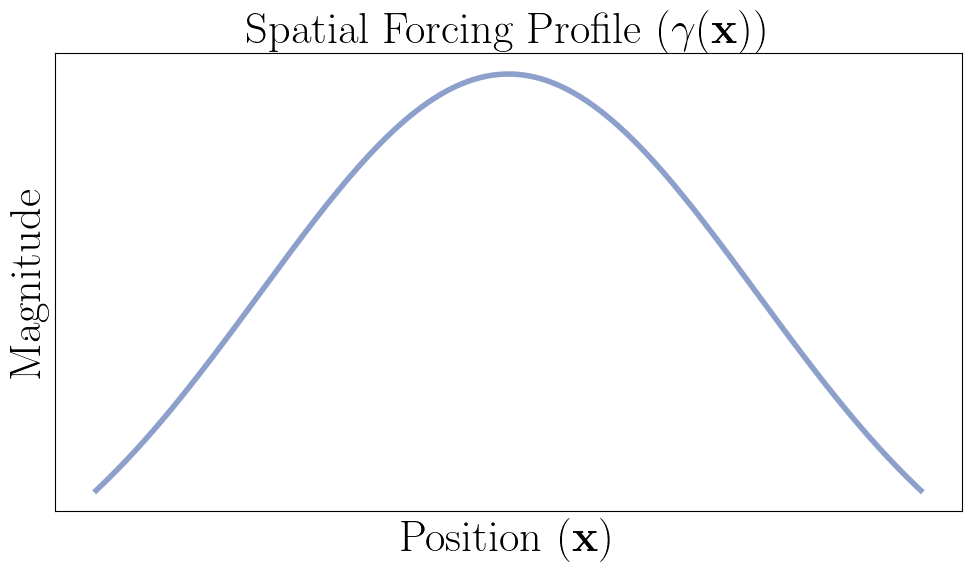

In [100]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(gamma,lw=4,c=brewer2_light(2))
ax.tick_params(axis='both', which='major', labelsize=28)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_xlabel(r'Position ($\mathbf{x}$)',fontsize=32)
ax.set_ylabel(r'Magnitude',fontsize=32)
ax.set_title(r'Spatial Forcing Profile ($\gamma(\mathbf{x})$)',fontsize=32)
plt.tight_layout()
plt.savefig('fig3_b.pdf',dpi=500)

In [128]:
G_opt = {}
for exp in experiments:
  # Assume the number of spatial points is the length of the gamma vector
  k = gamma.shape[0]
  lam, v = np.linalg.eig(L)
  w = np.linalg.pinv(v)

  G_opt[exp] = np.zeros((k, len(t)))

  for i, n in enumerate(t):
    # Create diagonal matrix of exp(lambda_i * t) for this particular time t
    exp_diag_trunc = np.diag(np.exp(lam * n))

    # Compute exp(L * t) using eigenvalue expansion: v * exp(diag(lambda) * t) * v^-1
    exp_Lt_trunc = v @ exp_diag_trunc @ w

    # Compute G(x, t) by multiplying exp(L * t) with gamma
    G_opt[exp][:, i] = np.dot(exp_Lt_trunc, gamma)
  
  break

import copy
for exp in experiments:
  G_opt[exp] = copy.copy(G_opt['2xCO2'])

/var/folders/5v/9rw_h5d56d57jgsmbk2dfb980000gn/T/ipykernel_85857/180948795.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  G_opt[exp][:, i] = np.dot(exp_Lt_trunc, gamma)


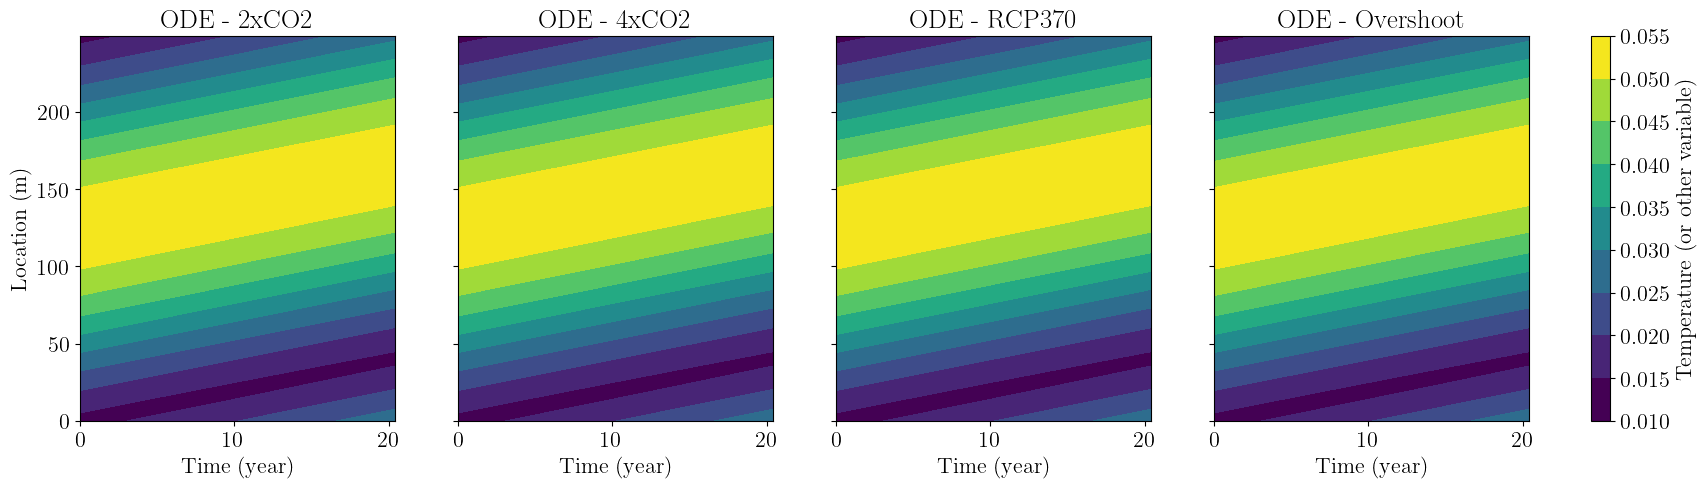

In [129]:
response_utils.plot_2D(G_opt, t_mesh, x_mesh, experiments, 'ODE')

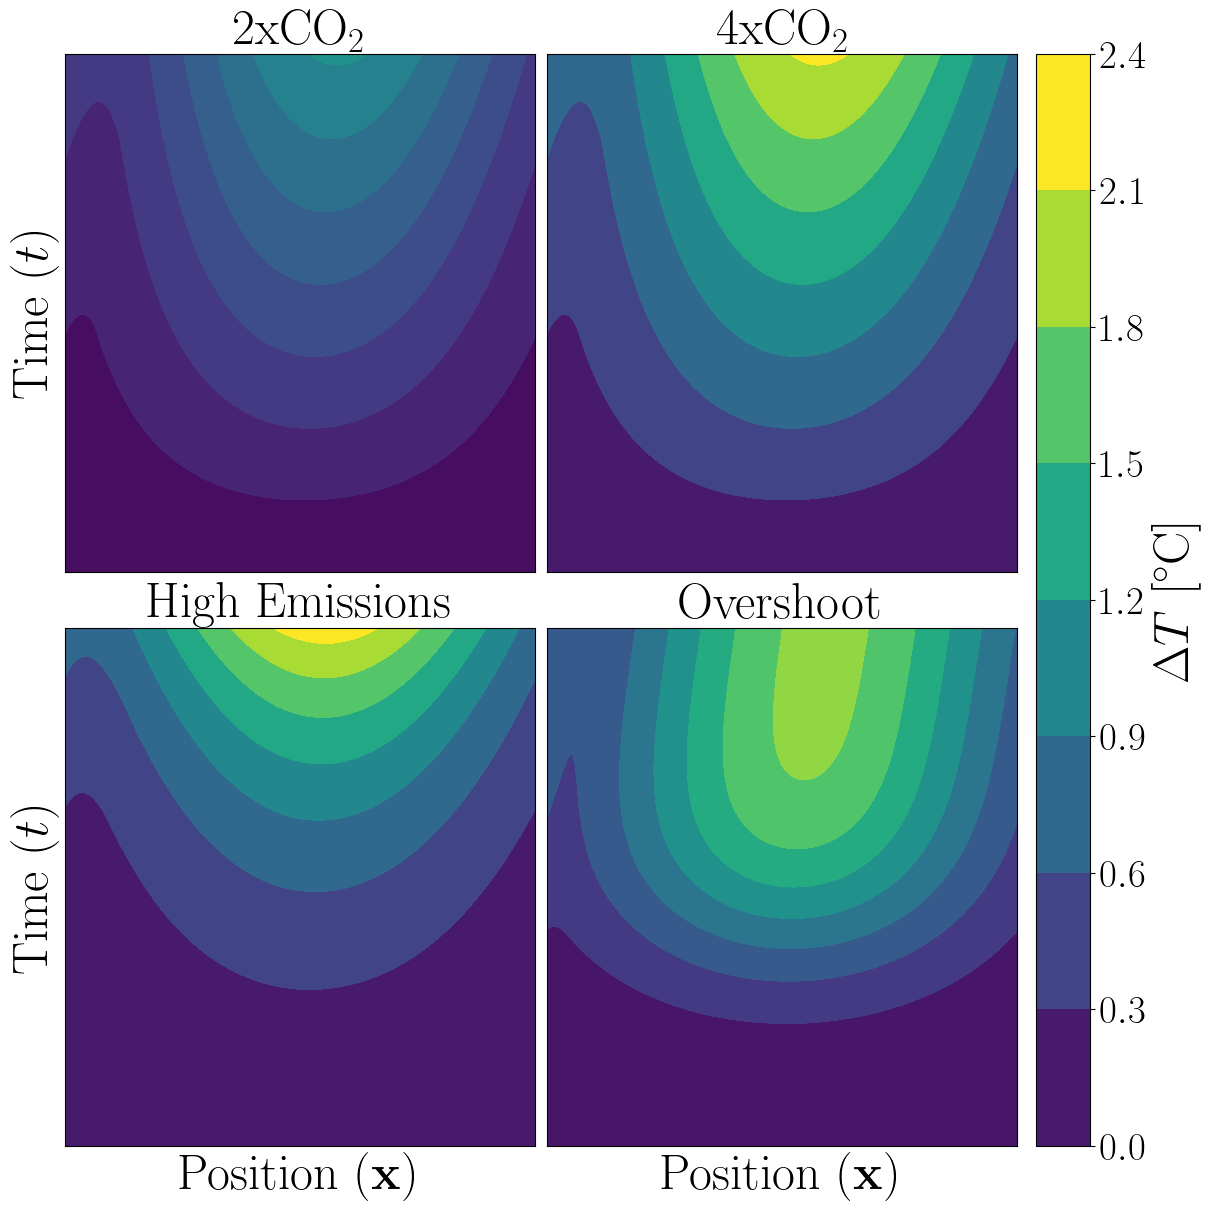

In [6]:
T_ode = {}
g_ode, a_ode = {}, {}
T_shape = np.zeros((N_x, N_t))
for exp in experiments:
  T_ode[exp] = response_utils.reconstruct_T_2D(F_all[exp], T_shape, L, ic, dt, gamma=gamma)
  g_ode[exp], a_ode[exp] = response_utils.calc_modes_2D(T_ode[exp])

response_utils.plot_2D2(T_ode, t_mesh, x_mesh, experiments, 'ODE')

#### Method 1: Direct derivation of Green's function

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO$_2$: 0.0
	L2 Error, 4xCO$_2$: 0.0
	L2 Error, High Emissions: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



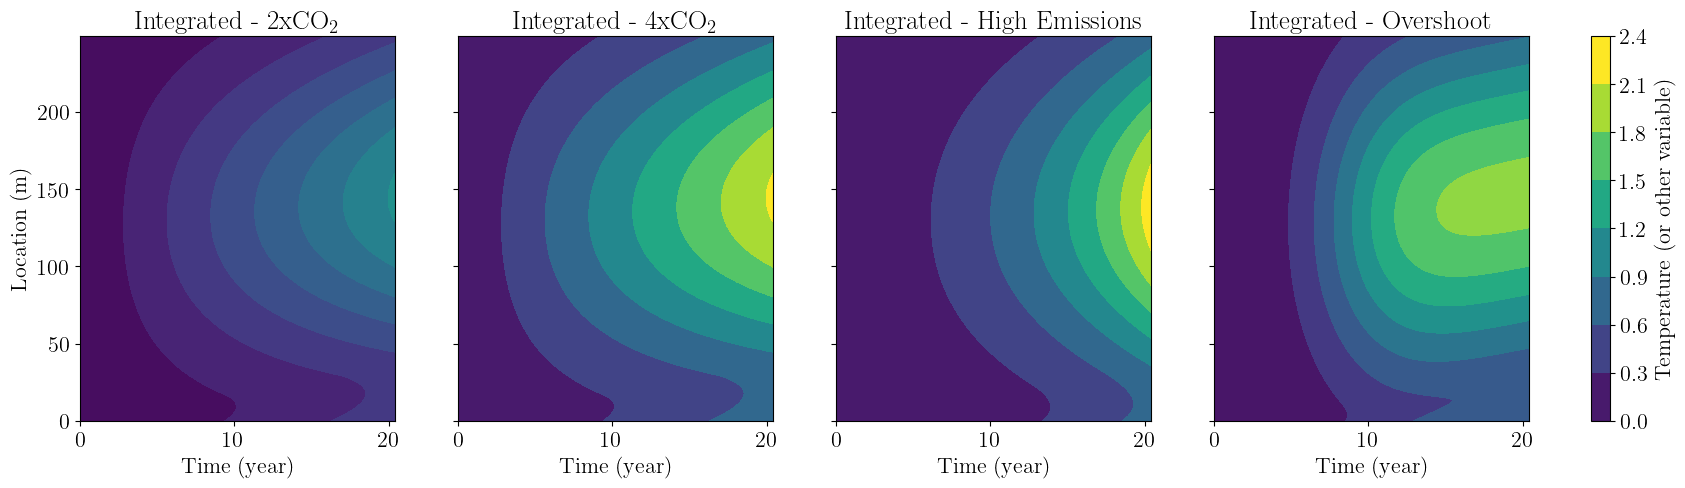

In [7]:
G_direct = {}
for exp in experiments:
  G_direct[exp] = response_utils.reconstruct_T_2D(F_del[exp], T_shape, L, ic, dt, gamma=gamma)

T_est_raw_1, T_est_modal_1 = response_utils.estimate_T_2D(T_ode, F_all,
                                                      experiments, t, 'G',
                                                      G_direct, None,
                                                      None, ic, dt)

response_utils.plot_2D(T_est_raw_1, t_mesh, x_mesh, experiments, 'Integrated')
L2_raw_1 = response_utils.calc_L2(T_ode, T_est_raw_1, experiments, None, 'Raw', coupled=True)

##### b) With Noise

#### Method 2: Direct inference of L from a dataset

##### a) Without noise

Text(0, 0.5, '$\\mathbf{x}^\\prime$')

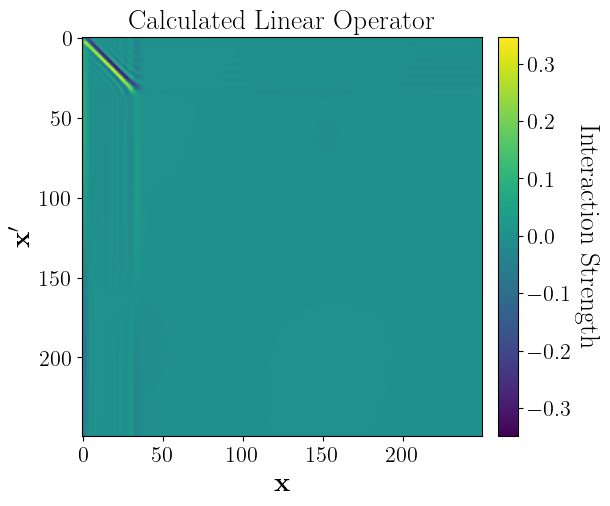

In [38]:
fig, ax = plt.subplots(figsize=(6,6),constrained_layout=True)
im = ax.imshow(L_raw[r'4xCO$_2$'])
cbar = fig.colorbar(im, fraction=0.05, pad=0.04)
cbar.ax.set_ylabel('Interaction Strength', rotation=270, labelpad=20, fontsize=20)
ax.set_title('Calculated Linear Operator',fontsize=20)
ax.set_xlabel(r'$\mathbf{x}$',fontsize=20)
ax.set_ylabel(r'$\mathbf{x}^\prime$',fontsize=20)

Error from Raw estimation.
	L2 Error, 2xCO$_2$: 0.19251
	L2 Error, 4xCO$_2$: 0.44159
	L2 Error, High Emissions: 1.59616
	L2 Error, Overshoot: 1.72754
Avg. L2 Error: 0.98945



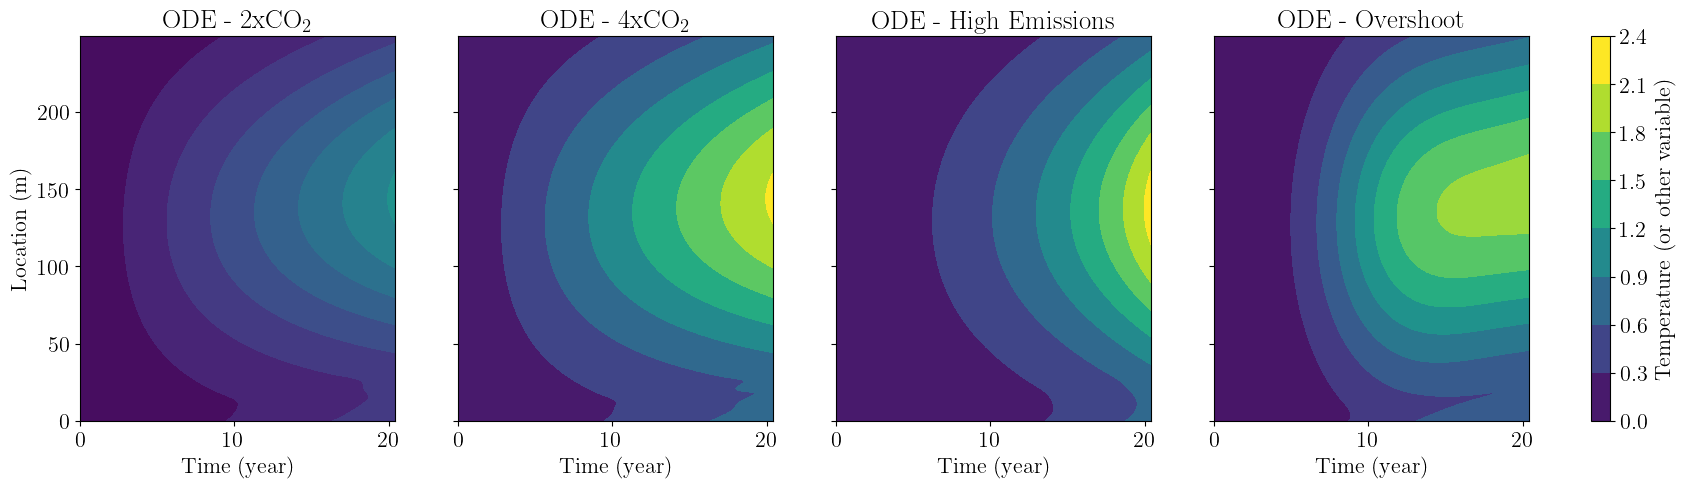

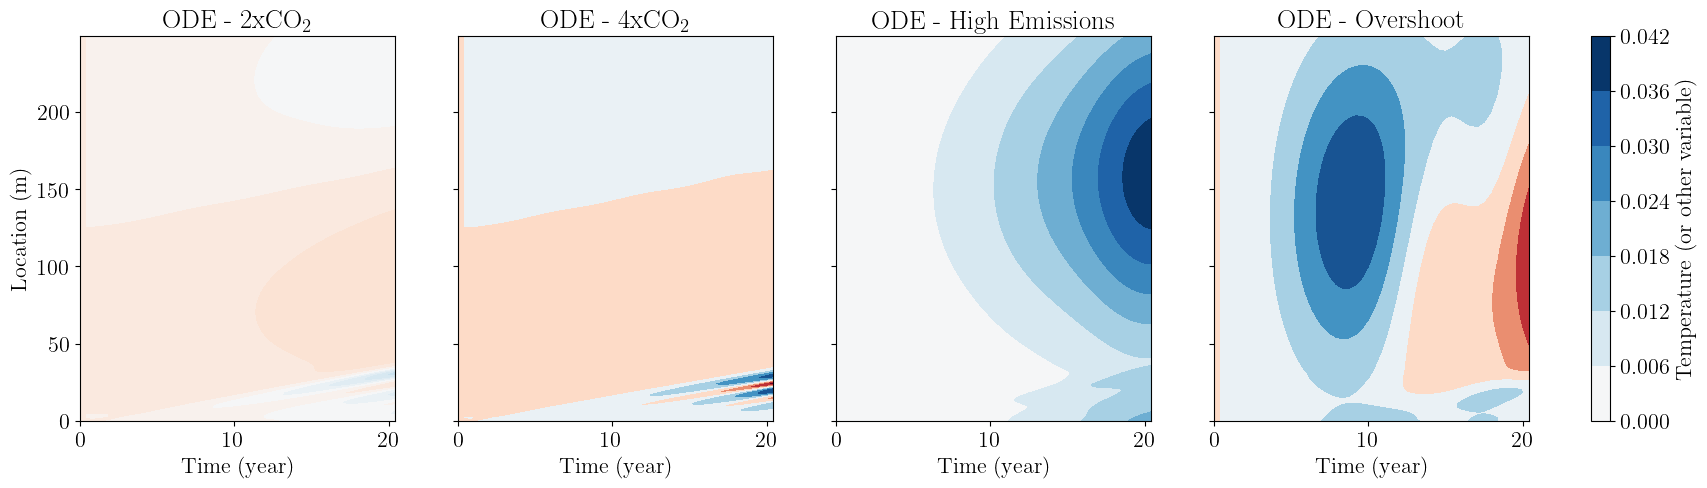

In [37]:
L_raw, L_modal = {}, {}
for exp in experiments:
  L_raw[exp] = response_utils.calc_L_direct_2D(T_ode[exp], F_all[exp], t, gamma=gamma)

T_est_raw_2, T_est_modal_2 = response_utils.estimate_T_2D(T_ode, F_all,
                                                      experiments, t, 'L',
                                                      L_raw, L_raw, None,
                                                      T0, dt, gamma)

response_utils.plot_2D(T_est_raw_2, t_mesh, x_mesh, experiments, 'ODE')
L2_raw_2 = response_utils.calc_L2(T_ode, T_est_raw_2, experiments, None, 'Raw', coupled=True)
response_utils.plot_2D(T_ode, t_mesh, x_mesh, experiments, 'ODE',T_est_raw_2)

##### b) With Noise

#### Method 3: Direct deconvolution of response function from dataset

##### a) Without noise

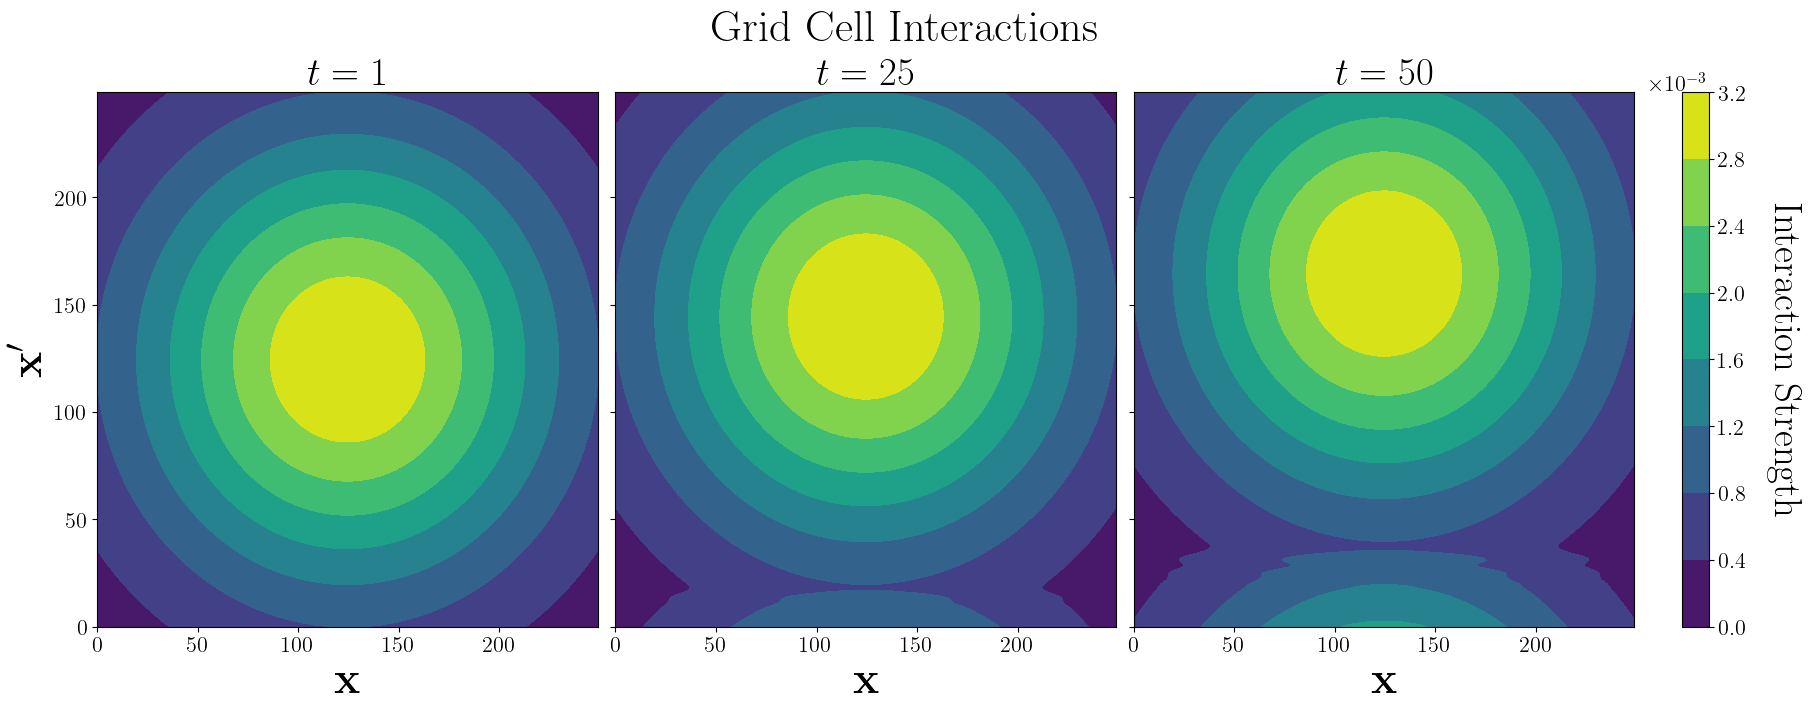

In [31]:
from matplotlib.ticker import ScalarFormatter

x_mesh2, x_mesh3 = np.meshgrid(x, x)
t_test = 1
exp = 'High Emissions'
fig, ax = plt.subplots(1,3, figsize=(18,7), sharey=True, constrained_layout=True)
cf = ax[0].contourf(x_mesh2, x_mesh3, np.array(G_deconv[exp])[:,:,1])
ax[1].contourf(x_mesh2, x_mesh3, np.array(G_deconv[exp])[:,:,25])
ax[2].contourf(x_mesh2, x_mesh3, np.array(G_deconv[exp])[:,:,49])

ax[0].set_xlabel(r'$\mathbf{x}$',fontsize=32)
ax[1].set_xlabel(r'$\mathbf{x}$',fontsize=32)
ax[2].set_xlabel(r'$\mathbf{x}$',fontsize=32)

ax[0].set_ylabel(r'$\mathbf{x}^\prime$',fontsize=32)

ax[0].set_title(r'$t = 1$',fontsize=28)
ax[1].set_title(r'$t = 25$',fontsize=28)
ax[2].set_title(r'$t = 50$',fontsize=28)

fig.suptitle('Grid Cell Interactions', fontsize=32)

cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.01)
cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cbar.ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
cbar.set_label('Interaction Strength',fontsize=28,rotation=270,labelpad=40)


In [34]:
G_arr = np.array(G_deconv['High Emissions'])

In [42]:
t

array([ 0.        ,  0.41666667,  0.83333333,  1.25      ,  1.66666667,
        2.08333333,  2.5       ,  2.91666667,  3.33333333,  3.75      ,
        4.16666667,  4.58333333,  5.        ,  5.41666667,  5.83333333,
        6.25      ,  6.66666667,  7.08333333,  7.5       ,  7.91666667,
        8.33333333,  8.75      ,  9.16666667,  9.58333333, 10.        ,
       10.41666667, 10.83333333, 11.25      , 11.66666667, 12.08333333,
       12.5       , 12.91666667, 13.33333333, 13.75      , 14.16666667,
       14.58333333, 15.        , 15.41666667, 15.83333333, 16.25      ,
       16.66666667, 17.08333333, 17.5       , 17.91666667, 18.33333333,
       18.75      , 19.16666667, 19.58333333, 20.        , 20.41666667])

In [58]:
np.shape(G_arr @ np.linalg.pinv(np.reshape(t,(1, len(t)))))

(250, 250, 1)

In [57]:
np.shape(np.linalg.pinv(np.reshape(t,(len(t),1))))

(1, 50)

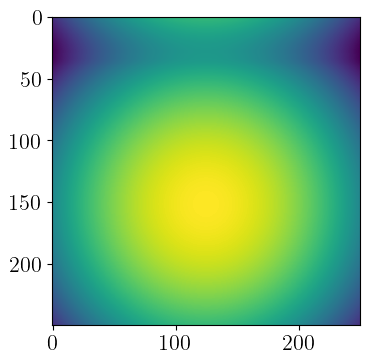

In [61]:
i = 10
plt.imshow(np.log(G_arr[:,:,1:]) @ np.linalg.pinv(np.reshape(t[1:],(1, len(t)-1))))

Error from Raw estimation.
	L2 Error, 2xCO$_2$: 0.0
	L2 Error, 4xCO$_2$: 0.0
	L2 Error, High Emissions: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



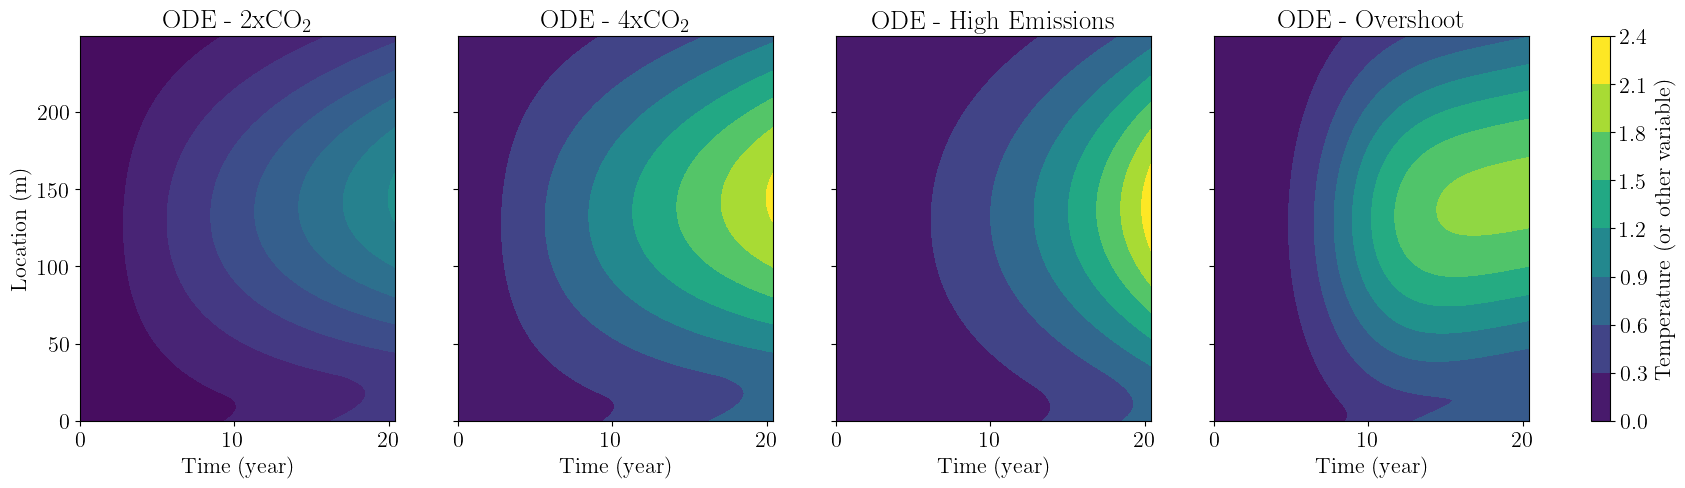

In [29]:
G_deconv = {}
for exp in experiments:
    G_deconv[exp] = []
    for i in range(len(x)):
        G_deconv[exp].append(response_utils.calc_G_deconv_2D(T_ode[exp][i], F_all[exp], dt=1, gamma=gamma))

T_est_raw_3, T_est_modal_3 = response_utils.estimate_T_2D(T_ode, F_all,
                                                      experiments, t, 'G',
                                                      G_deconv, None,
                                                      None, ic, dt, gamma)

response_utils.plot_2D(T_est_raw_3, t_mesh, x_mesh, experiments, 'ODE')
L2_raw_3 = response_utils.calc_L2(T_ode, T_est_raw_3, experiments, None, 'Raw', coupled=True)

Error from Raw estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, RCP370: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



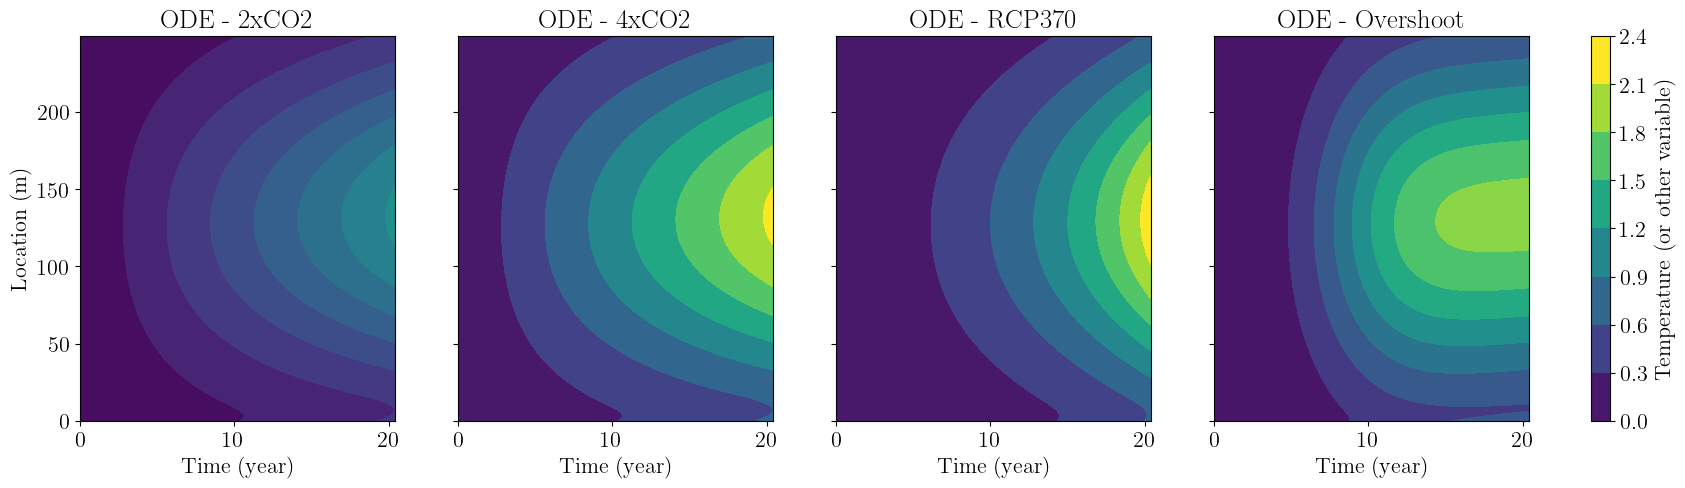

In [211]:
G_deconv, g_deconv, a_deconv = {}, {}, {}
for exp in experiments:
    G_deconv[exp] = response_utils.calc_G_deconv_2D(T_ode[exp], F_all[exp], dt=1)

T_est_raw_3, T_est_modal_3 = response_utils.estimate_T_2D(T_ode, F_all,
                                                      experiments, t, 'G',
                                                      G_deconv, None,
                                                      None, T0, dt)

response_utils.plot_2D(T_est_raw_3, t_mesh, x_mesh, experiments, 'ODE')
L2_raw_3 = response_utils.calc_L2(T_ode, T_est_raw_3, experiments, None, 'Raw', coupled=True)

##### b) With Noise

#### Method 4: Estimation of response function using only leading timescales

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO2: 2.05687
	L2 Error, 4xCO2: 4.11481
	L2 Error, RCP370: 1.75184
	L2 Error, Overshoot: 6.0883
Avg. L2 Error: 3.50296



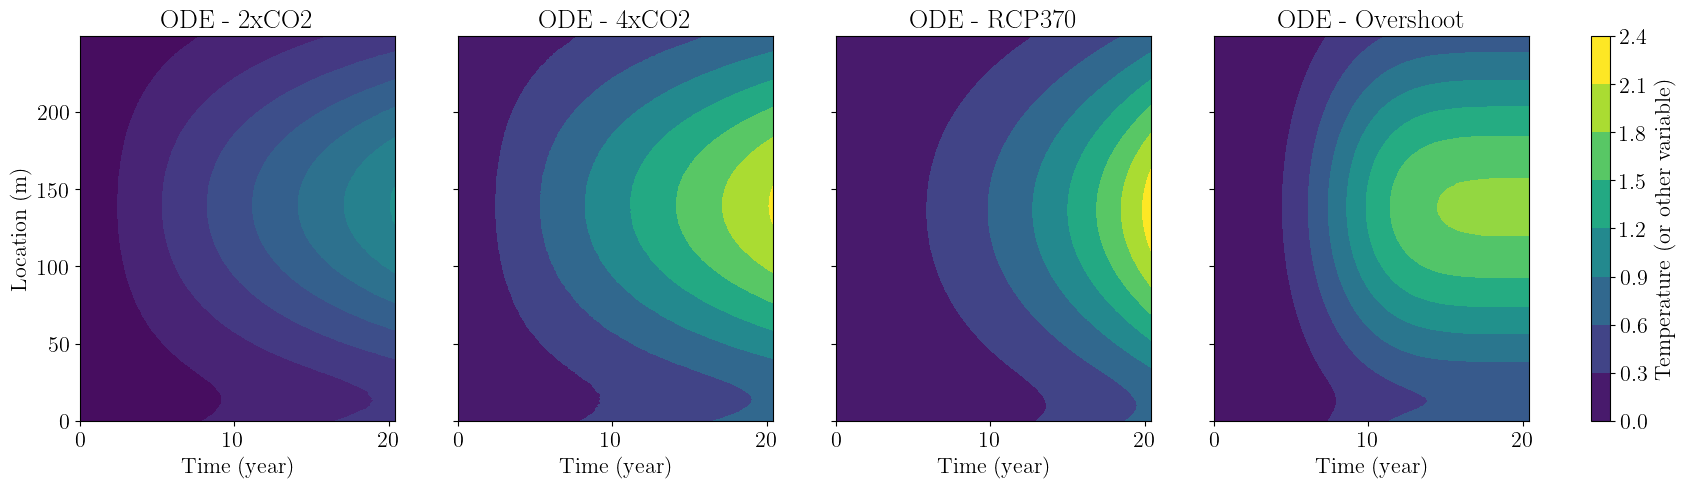

In [60]:
m = 2
k = len(x)

initial_v = np.random.rand(m * k)  # Flattened eigenvector
initial_lam = -np.random.rand(m)      # Eigenvalues
initial_params = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector
bounds = [(None, None)] * (m * k) + [(-1, 0)] * m

res_raw, res_modal = {}, {}
G_fit, a_fit = {}, {}

for exp in experiments:
  res_raw[exp] = minimize(response_utils.opt_v_lam_2D,
                                initial_params,
                                args=(T_ode[exp], F_all[exp], t, m, dt, gamma),
                                method='L-BFGS-B',
                                bounds=bounds)

  G_fit[exp] = response_utils.apply_v_lam_2D(res_raw[exp].x, t, m, gamma, dt)

T_est_raw_4, T_est_modal_4 = response_utils.estimate_T_2D(T_ode, F_all,
                                                      experiments, t, 'G',
                                                      G_fit, None,
                                                      None, T0, dt)

response_utils.plot_2D(T_est_raw_4, t_mesh, x_mesh, experiments, 'ODE')
L2_raw_4 = response_utils.calc_L2(T_ode, T_est_raw_4, experiments, None, 'Raw', coupled=True)


##### b) With Noise